# Computer Vision (CV2022): Assignment 5

### - Avirup Das (MDS202013)


In [2]:
# importing libraries
import cv2, time
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# fetching images
!rm *.jpg *.png
!gdown --id 1WlW7x7lYVRyStR8KcS61s5t9-pwEbh9e
!unzip Filtering.zip

rm: cannot remove '*.jpg': No such file or directory
rm: cannot remove '*.png': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1WlW7x7lYVRyStR8KcS61s5t9-pwEbh9e
To: /content/Filtering.zip
100% 361k/361k [00:00<00:00, 64.4MB/s]
Archive:  Filtering.zip
  inflating: Filtering/ZebrawithShadow.jpg  
  inflating: Filtering/cameraman.jpg  
  inflating: Filtering/ricegrains.jpg  
  inflating: Filtering/moon.jpg      
  inflating: Filtering/tigerbw.jpg   
  inflating: Filtering/penguins.jpg  
  inflating: Filtering/RBCs.bmp      


### Helper functions

In [4]:
# Display Subplots
def disp_subplots(image, shape, titles, sup_title, axes, figsize, cmap=None):
  fig, ax = plt.subplots(shape[0], shape[1], figsize=figsize)
  try:
    ax = ax.ravel()
  except:
    pass
    
  for i in range(len(image)):
    if cmap is None:
      ax[i].imshow(image[i])
    else:
      ax[i].imshow(image[i], cmap=cmap)

    if axes[i] is None:
      ax[i].set_xticks([])
      ax[i].set_yticks([])

    if titles[i] is not None:
      ax[i].set_title(titles[i])

  if sup_title is not None:
    fig.suptitle(sup_title, fontsize=18)
  plt.show()

# Function to generate strip images
def strip_img(width=2, shape=(200,200)):
  img = np.zeros(shape)
  M,N = shape
  strip = 'w'

  for i in range(0, N, width):
    if strip == 'b':
      img[:,i:(i+width)]=0
      strip='w'
    else:
      img[:,i:(i+width)]=255
      strip='b'

  return img

# Function to create image of size 100x100 with a white rectangle at the center
def make_rect(size):
  img = np.zeros((100,100), dtype = np.uint8)
  M,N = img.shape
  c_row = M//2
  c_col = N//2
  rec_m, rec_n = size
  # creating rectangle in the middle
  img[(c_row - (rec_m//2)): (c_row+(rec_m//2)), 
      (c_col - (rec_n//2)): (c_col+(rec_n//2))] = 255
    
  return img

# Function to apply Butterworth Lowpass Filter to image
def butterworth_lowpass(img, radius, n):
  fshift = np.fft.fftshift(np.fft.fft2(img))
  M,N = img.shape
  out = np.zeros((M,N))
  cx = round(M/2)
  cy = round(N/2)
  H = np.zeros((M,N))
  
  for i in range(M):
    for j in range(N):
      d = np.sqrt((i-cx)**2 + (j-cy)**2)
      H[i,j] = 1/(1+((d/radius)**(2*n)))
            
  out_fourier = fshift * H
  out = np.abs(np.fft.ifft2(out_fourier))
  return out

# Function to apply Gaussian Lowpass Filter on image
def gaussian_lowpass(img, radius):
  fshift = np.fft.fftshift(np.fft.fft2(img))
  M,N = img.shape
  out = np.zeros((M,N))
  cx = round(M/2)
  cy = round(N/2)
  H = np.zeros((M,N))
    
  for i in range(M):
    for j in range(N):
      d = (i-cx)**2 + (j-cy)**2
      H[i,j] = np.exp(-(d/(2*(radius**2))))
            
  out_fourier = fshift * H
  out = np.abs(np.fft.ifft2(out_fourier))
  return out.astype(np.uint8)

# Function to apply Butterworth Highpass Filter on image
def butterworth_highpass(img, radius, n):
  fshift = np.fft.fftshift(np.fft.fft2(img))
  M,N = img.shape
  out = np.zeros((M,N))
  cx = round(M/2)
  cy = round(N/2)
  H = np.zeros((M,N))
  
  for i in range(M):
    for j in range(N):
      d = np.sqrt((i-cx)**2 + (j-cy)**2)
      H[i,j] = 1/(1+((d/radius)**(2*n)))
  H = (1 - H)
  out_fourier = fshift * H
  out = np.abs(np.fft.ifft2(out_fourier))
  return out

# Function to apply Gaussian Highpass Filter on image
def gaussian_highpass(img, radius):
  fshift = np.fft.fftshift(np.fft.fft2(img))
  M,N = img.shape
  out = np.zeros((M,N))
  cx = round(M/2)
  cy = round(N/2)
  H = np.zeros((M,N))
  
  for i in range(M):
    for j in range(N):
      d = (i-cx)**2 + (j-cy)**2
      H[i,j] = np.exp(-(d/(2*(radius**2))))
    
  H = 1 - H
  out_fourier = fshift * H
  out = np.abs(np.fft.ifft2(out_fourier))
  return out.astype(np.uint8)

# Function to pad image
def pad_img(img, new_shape):
  M,N = img.shape
  new_M, new_N = new_shape
  padded_img = np.zeros((new_M, new_N))
  padded_img[:M,:N] = img
  return padded_img

## Question 1

### Part a: 
Consider the function $f(t)=\sin(2\pi nt)$, where $n$ is an integer. Its Fourier transform, $F(m)$, is purely imaginary. Because the transform, $\tilde{F}(m)$, of sampled data consists of periodic copies of $F(m)$, it follows that $\tilde{F}(m)$ will also be purely imaginary. Draw a diagram similar to Fig. 4.6, and answer the following questions based
on your diagram (assume that sampling starts at $t = 0$).

- (a) What is the period of $f(t)$?
- (b) What is the frequency of $f(t)$?
- (c) What would the sampled function and its Fourier transform look like in general if $f(t)$ is sampled at a rate higher than the Nyquist rate?
- (d) What would the sampled function look like in general if $f(t)$ is sampled at a rate lower than the Nyquist rate?
- (e) What would the sampled function look like if $f(t)$ is sampled at the Nyquist rate, with samples taken at $t = 0,±\Delta T,±2\Delta T, \ldots $ ?

<br>$\textit{Solution:}$ 

- (a) The period is such that $2\pi nt = 2\pi \ \Rightarrow t= \dfrac{1}{n}$
- (b) The frequency would be 1 over the period $= \dfrac{1}{1/n}=n$
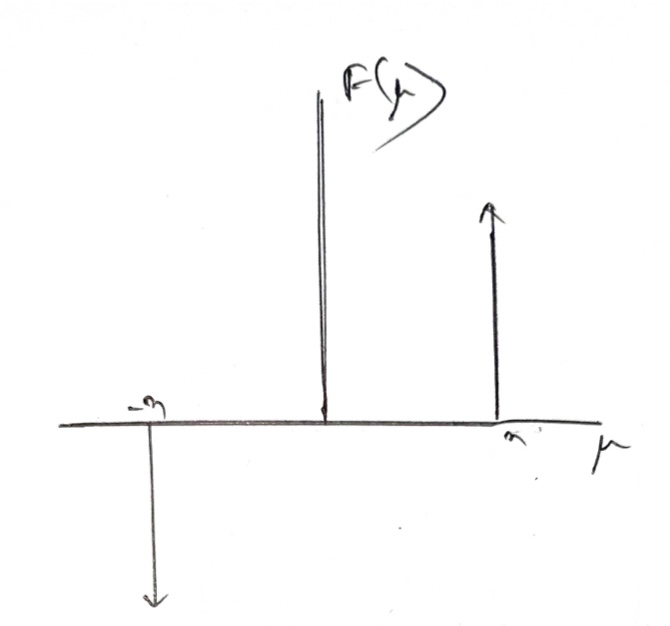
- (c) We know that the Nyquist sampling rate is twice the highest frequency which is $n$ here. Hence the Nyquist sampling rate is $2n$. Suppose $f(t)$ is sampled at a rate higher than the Nyquist rate (let the rate be $2n+\epsilon, \ \epsilon >0$). In this case the sampled function will behave as $f(t)$ without any significant loss. 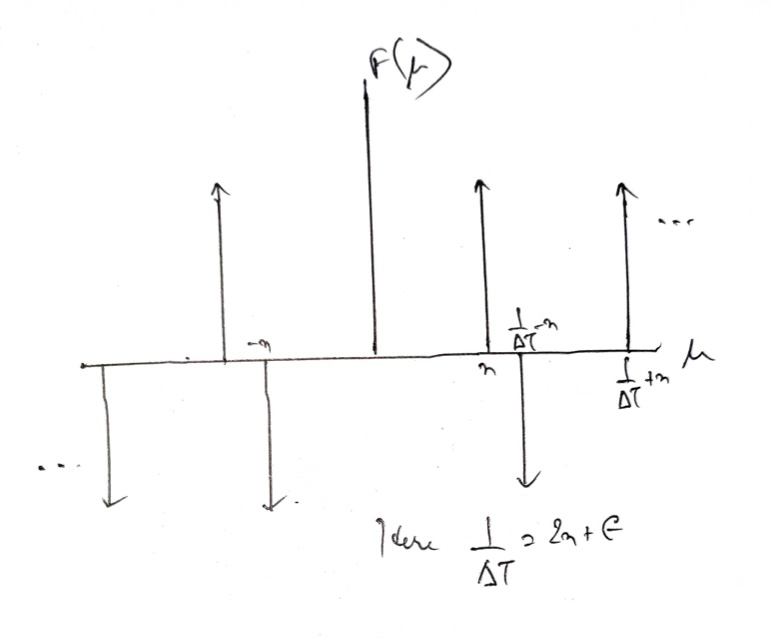  

This is an inifnite repititions of the Fourier transform of $f(t) which can be restored when we perform inverse FT as there is no overlap between the copies or repititions. 

- (d) If $f(t)$ is sampled at a rate lower than the Nyquist rate, the original function cannot be restored and the resultant function will behave as a combination of two sine functions. Let us assume that the sampling rate is $2n-\epsilon, \ \epsilon >0$ then the Fourier transform would look like the following:


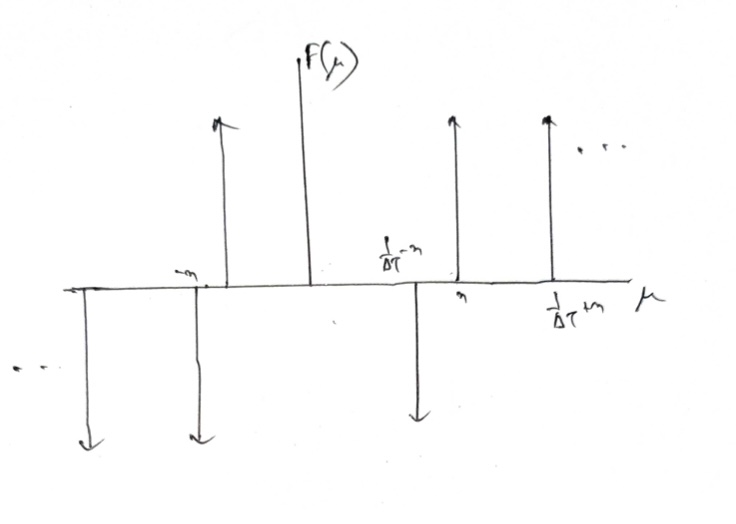

Clearly there is an overlap between the copies and hence when Inverse FT is performed, the function would look similar to a combination of two sine functions instead of the original function.

- (e) We know that the Nyquist sampling rate is $2n$ here, i.e., $(1/ \Delta T)=2n \ \Rightarrow \Delta T = \dfrac{1}{2n}$. 
So if we take samples at $t=\pm \Delta T, \pm 2\Delta T, \ldots, $ it would produce the sampled function $sin(2\pi n \Delta T)$ whose values are all 0s because $\Delta T = \dfrac{1}{2n}$ and $n$ is an integer.Pictorially, when $\Delta T = \dfrac{1}{2n}$ all the positive and negative impulses would coincide, thus cancelling each other and producing a result of 0 for the sampled data (which can be observed from the previous diagrams if $\epsilon=0$)

### Part b:

Show that the 1-D convolution theorem given in Eqs. (4-25) and (4-26) also holds for discrete variables, but with the right side of Eq. (4-26) multiplied by $1/M$. That is, show that
- (a) $( f \star h)( x) \Leftrightarrow (F \cdot H )(u)$, and
- (b) $(f\cdot h)(x) \Leftrightarrow \dfrac{1}{M} (F \star H)(u) $

<br>$\textit{Solution}:$ <br>
$\begin{align}
\text{(a) } \mathscr{F}[(f\star h)(x)] &= \mathscr{F}[f(x) \star h(x)] = \mathscr{F}\left[\sum_{m=0}^{M-1}f(m) h(x-m)\right] \ [\text{By equation 4.4-48}] \\
&= \sum_{x=0}^{M-1} \left[\sum_{m=0}^{M-1}f(m) h(x-m)\right] e^{-j2\pi u x/M} = \sum_{m=0}^{M-1}f(m) \left[\sum_{x=0}^{M-1}h(x-m) e^{-j2\pi ux/M}\right]\\
&= \sum_{m=0}^{M-1} f(m) H(u) e^{-j2\pi um/M} = H(u) \sum_{m=0}^{M-1} f(m) e^{-j2\pi um/M}\\
&= H(u) F(u)\\
\Rightarrow ( f \star h)( x) &\Leftrightarrow (F \cdot H )(u) \qquad (Proved)
\end{align}$

$\begin{align}
\text{(b) } \mathscr{F}[(f \cdot h)(x)] & = \mathscr{F}[f(x) \cdot h(x)] = \sum_{x=0}^{M-1} f(x)\cdot h(x) \ e^{-j2\pi ux/M}\\
&= \sum_{x=0}^{M-1} \left( \dfrac{1}{M}\sum_{m=0}^{M-1}F(m)e^{j2\pi mx/M} \right)\cdot h(x) \ e^{-j2\pi ux/M} \quad [\text{Applying Inverse DFT on } f(x)]\\
&= \dfrac{1}{M}\sum_{m=0}^{M-1}F(m) \sum_{x=0}^{M-1} h(x)e^{-j2\pi x(u-m)/M}\\
&= \dfrac{1}{M}\sum_{m=0}^{M-1}F(m) H(u-m) = \dfrac{1}{M}F(u)H(u)\\
\Rightarrow (f\cdot h)(x) &\Leftrightarrow \dfrac{1}{M}F(u)H(u) \qquad (Proved)
\end{align}$

### Part c:

- (a) Suppose that the stripes of an image of the same size are four pixels wide. Sketch what the spectrum of the image would look like, including only the dc term and the two highest-value frequency terms, which correspond to the two spikes in the spectrum above.

- (b) Why are the components of the spectrum limited to the horizontal axis?

- (c) What would the spectrum look like for an image of the same size but having stripes that are one pixel wide? Explain the reason for your answer.

- (d) Are the dc terms in (a) and (c) the same, or are they different? Explain.


<br>$\textit{Solution}:$ <br>

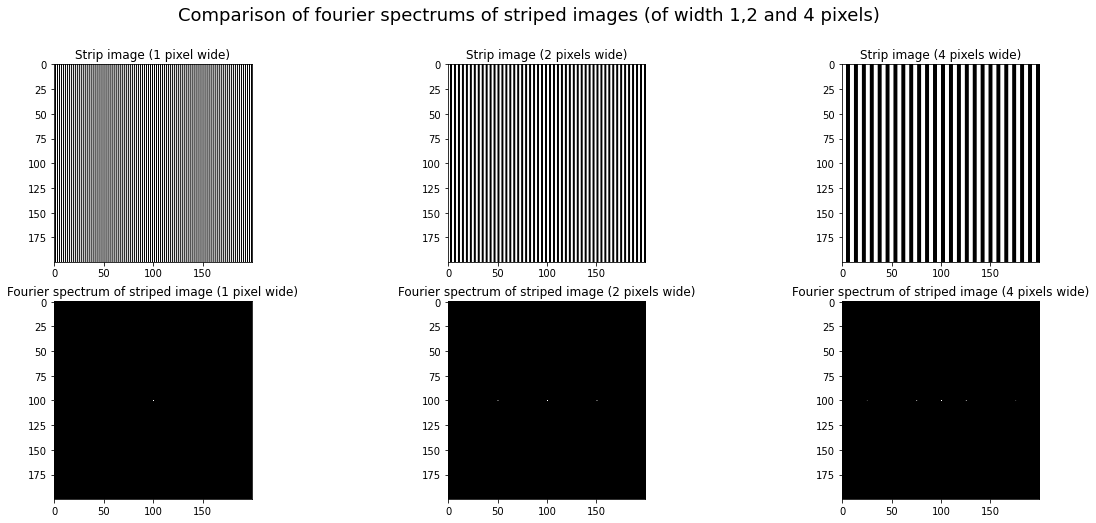

In [5]:
# Magnitude spectrums for 1, 2 and 4 pixels
img1pix = strip_img(width = 1)
magnitude_spectrum1pix = np.abs(np.fft.fftshift(np.fft.fft2(img1pix)))

img2pix = strip_img()
magnitude_spectrum2pix = np.abs(np.fft.fftshift(np.fft.fft2(img2pix)))

img4pix = strip_img(width = 4)
magnitude_spectrum4pix = np.abs(np.fft.fftshift(np.fft.fft2(img4pix)))

disp_subplots([img1pix, img2pix, img4pix, magnitude_spectrum1pix,
               magnitude_spectrum2pix, magnitude_spectrum4pix], (2,3),
               ['Strip image (1 pixel wide)', 'Strip image (2 pixels wide)',
                'Strip image (4 pixels wide)',
                'Fourier spectrum of striped image (1 pixel wide)',
                'Fourier spectrum of striped image (2 pixels wide)', 
                'Fourier spectrum of striped image (4 pixels wide)'],
               'Comparison of fourier spectrums of striped images (of width 1,2 and 4 pixels)',
               [1]*6, (20,8), cmap='gray')

In [6]:
M,N = img2pix.shape
magnitude_spectrum1pix[M//2, N//2], magnitude_spectrum4pix[M//2, N//2]

(5100000.0, 5100000.0)

- (a) Subplots at (1,3) and (2,3) are the required striped image (of width 4 pixels) and its corresponding fourier spectrum, including only the dc term and the two highest-value frequency terms, which correspond to the two spikes in the spectrum above

- (b) The components of the fourier spectrum are limited only to the x-axis since the intensity of the pixel values change while moving along the x-axis from one pixel to another. The change in frequency along the y-axis is zero.

- (c) Subplots at (1,1) and (2,1) are the required striped image (of width 4 pixels) and its corresponding fourier spectrum, including only the dc term and the two highest-value frequency terms, which correspond to the two spikes in the spectrum above

- (d) Dc terms in both the images (with width 1 pixel and 4 pixels) are the same since the central dc component is nothing but the average brightness of the image which is essentially the same for both cases.

## Question 2

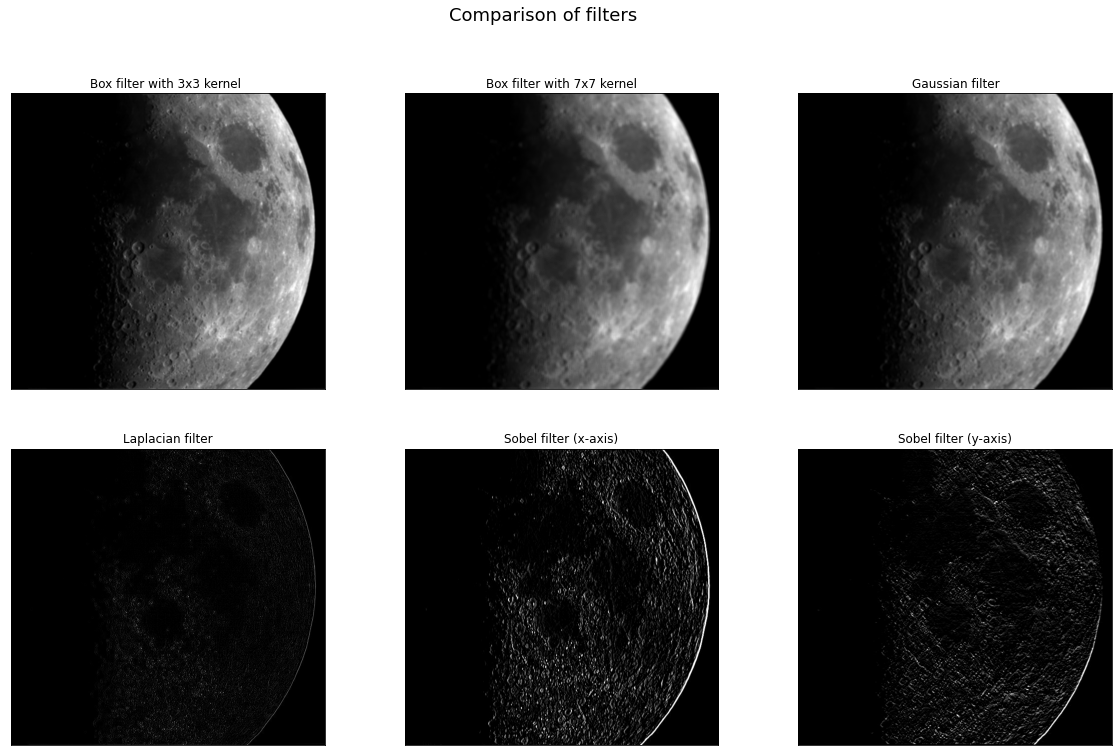

In [7]:
# Reading moon.jpg
img = cv2.imread('Filtering/moon.jpg', 0)

# Box filter of size 3x3
box1 = np.ones((3,3))/(3*3)

# Box filter of size 7x7
box2 = np.ones((7,7))/(7*7)

# Gaussian filter of size 5x5 with sd=10
temp = cv2.getGaussianKernel(5,10)
gauss = temp*temp.T

# laplacian filter
lap = np.array([[0, 1, 0],[1,-4, 1],[0, 1, 0]])

# Sobel in x-direction
sobel_x = cv2.flip(np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]),-1)

# Sobel in y-direction
sobel_y = cv2.flip(np.array([[-1,-2,-1],[0, 0, 0],[1, 2, 1]]),-1)

filters = [box1, box2, gauss, lap, sobel_x, sobel_y]
filter_name = ['Box filter with 3x3 kernel ', 'Box filter with 7x7 kernel',
               'Gaussian filter','Laplacian filter', 'Sobel filter (x-axis)', 
               'Sobel filter (y-axis)']

# Initializing the array storing the filtered images
filtered_img = []

# Applying filters
for i in filters:
  filtered_img.append(cv2.filter2D(img, -1, i))

# Displaying results
disp_subplots(filtered_img, (2,3), filter_name, 'Comparison of filters', [None]*6, (20,12), cmap='gray')

## Question 3

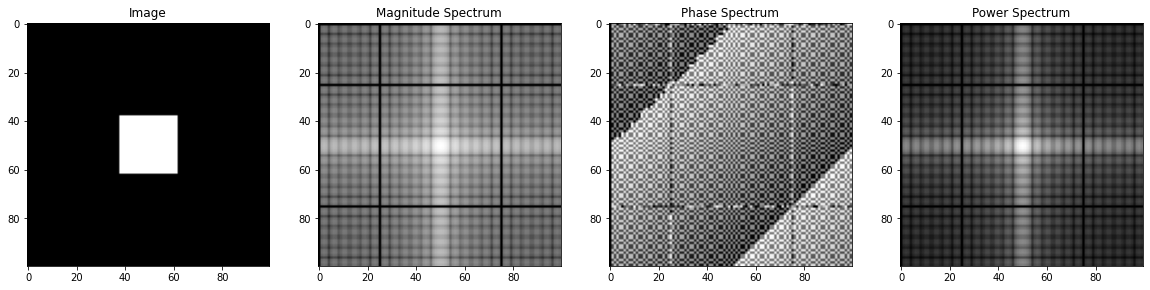

In [8]:
# Image with white rectangle of size 25x25 in the middle
img = make_rect((25,25))
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum, phase_spectrum = cv2.cartToPolar(dft_shift[:,:,0],dft_shift[:,:,1])

magnitude_spectrum = 20 * np.log(1+magnitude_spectrum)
power_spectrum = np.power(magnitude_spectrum,2) 

disp_subplots([img, magnitude_spectrum, phase_spectrum, 
               power_spectrum], (1,4), ['Image', 'Magnitude Spectrum',
               'Phase Spectrum', 'Power Spectrum'], None, [1]*4, (20,8), cmap='gray')

## Question 4

### Part a: Spatial Domain Filtering

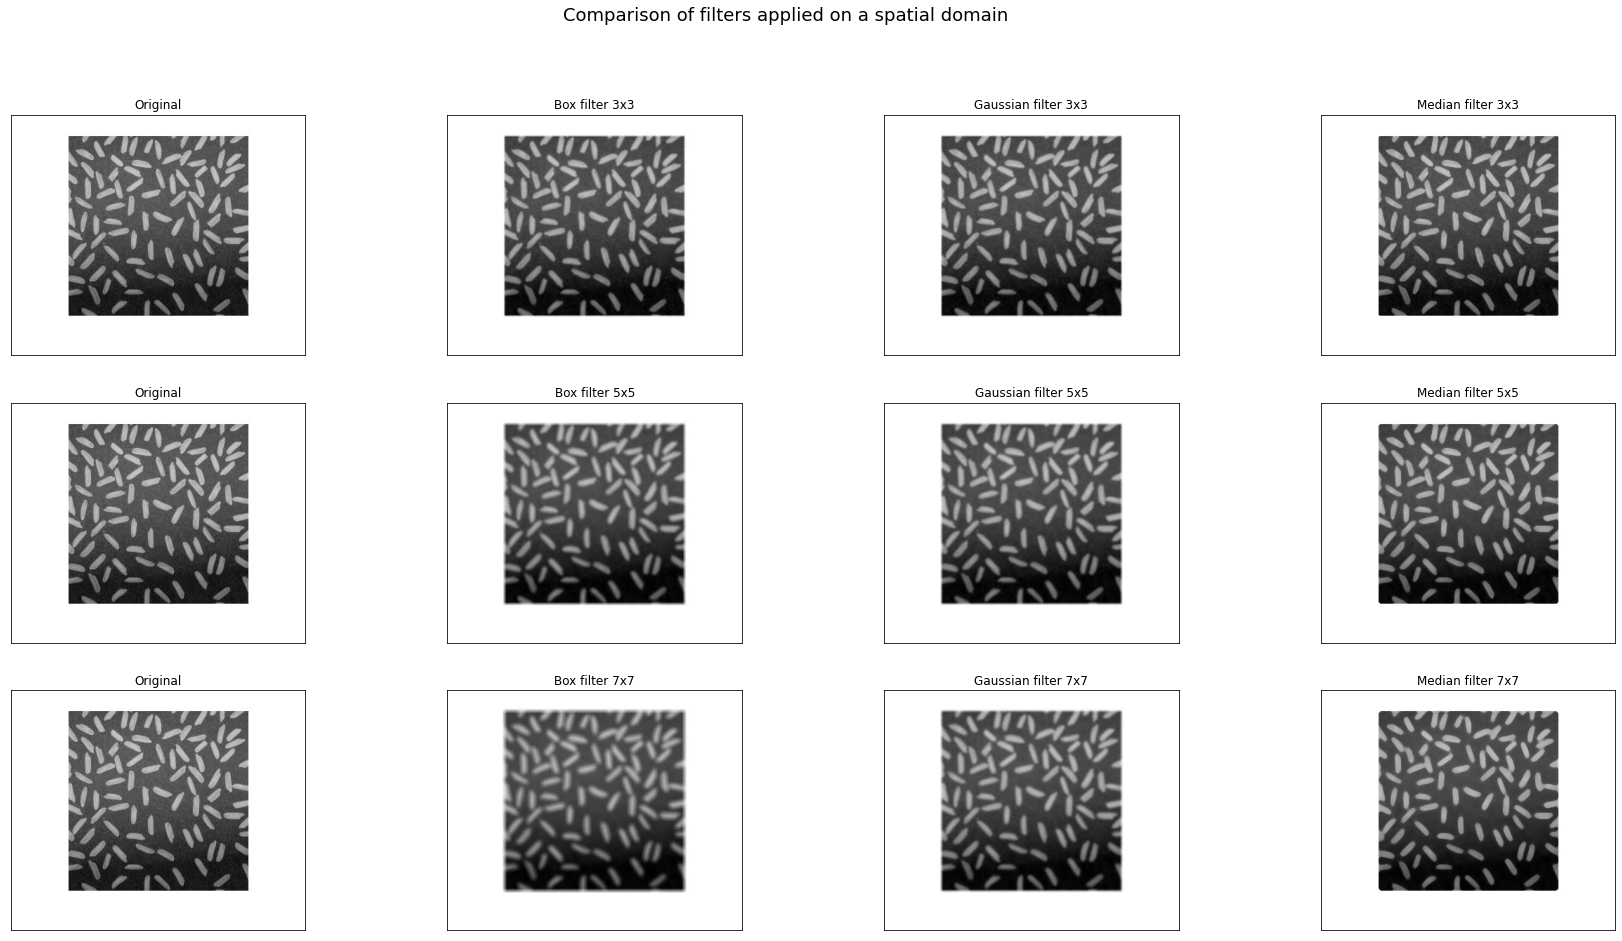

In [9]:
# Reading image ricegrains.jpg
img = cv2.imread('Filtering/ricegrains.jpg', 0)
# Defining kernel sizes
kernel_sizes = [3,5,7]
images, titles = [],[]

for i in kernel_sizes:
  box = cv2.blur(img , (i,i))
  gaussian = cv2.GaussianBlur(img, (i,i), 1.5)
  median = cv2.medianBlur(img, i)
  images.extend([img, box, gaussian, median])
  titles.extend(['Original', f'Box filter {i}x{i}', 
                 f'Gaussian filter {i}x{i}', f'Median filter {i}x{i}'])
  
disp_subplots(images, (3,4), titles, 'Comparison of filters applied on a spatial domain',
              [None]*12, (30,15), cmap='gray')

### Part b: Frequency Domain Filtering

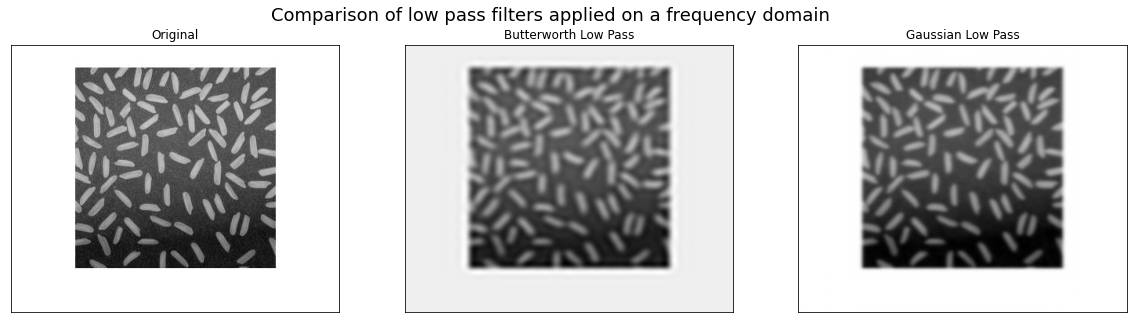

In [10]:
# Reading image ricegrains.jpg
img = cv2.imread('Filtering/ricegrains.jpg', 0)

# Passing filters over image
butterworth_img = butterworth_lowpass(img, 30, 4)
gauss_img = gaussian_lowpass(img, 30)

# Displaying results
disp_subplots([img, butterworth_img, gauss_img], (1,3), ['Original',
              'Butterworth Low Pass', 'Gaussian Low Pass'],
              'Comparison of low pass filters applied on a frequency domain',
              [None]*3, (20,5), cmap='gray')

## Question 5

### Part a: Spatial Domain Filtering

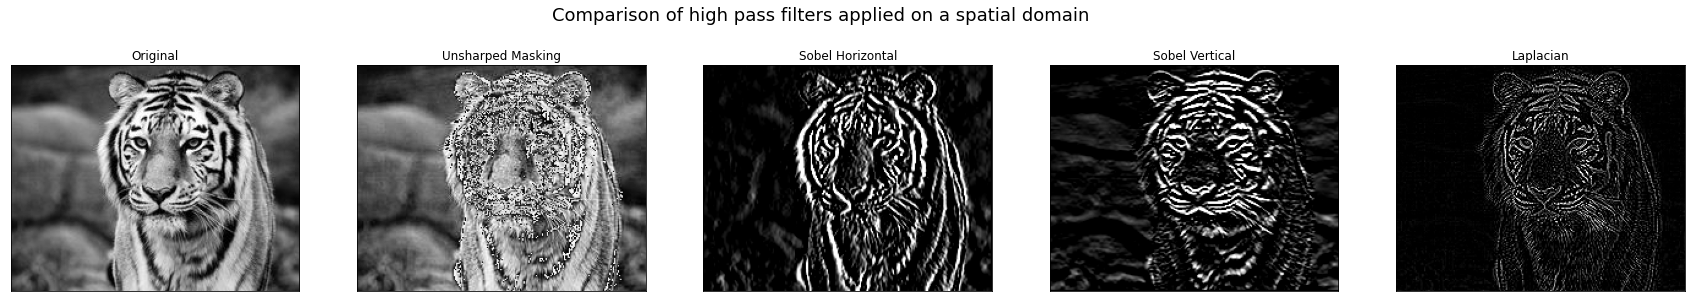

In [11]:
# Reading image tigerbw.jpg
img = cv2.imread('Filtering/tigerbw.jpg', 0)

# Unsharp Masking
K=1
temp = cv2.getGaussianKernel(5, 10)
gauss = temp * temp.T
blurred_img = cv2.filter2D(img, -1, gauss)
mask = img-blurred_img
unsharped_img = img + K*mask

# Sobel Edge Detector
sob_x = cv2.filter2D(img, -1, sobel_x)
sob_y = cv2.filter2D(img, -1, sobel_y)

# Laplace Edge Detector
lap_img = cv2.filter2D(img, -1, lap)

# Displaying results
disp_subplots([img, unsharped_img, sob_x, sob_y, lap_img], (1,5),
              ['Original','Unsharped Masking', 'Sobel Horizontal',
               'Sobel Vertical', 'Laplacian'],
              'Comparison of high pass filters applied on a spatial domain',
              [None]*5, (30,5), cmap='gray')

### Part b: Frequency Domain Filtering

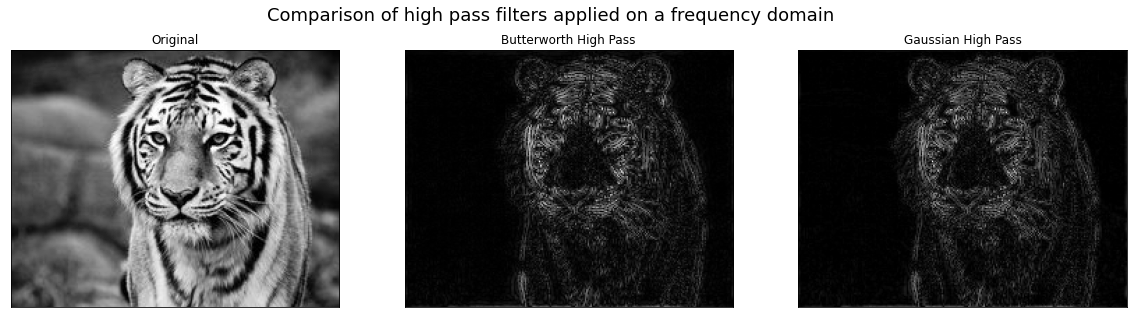

In [12]:
# Reading image tigerbw.jpg
img = cv2.imread('Filtering/tigerbw.jpg', 0)

# Highpass Butterworth
butter_img = butterworth_highpass(img, 30, 4)

# Highpass Gaussian
gauss_img = gaussian_highpass(img, 30)

# Displaying results
disp_subplots([img, butter_img, gauss_img], (1,3),
              ['Original','Butterworth High Pass', 'Gaussian High Pass'],
              'Comparison of high pass filters applied on a frequency domain',
              [None]*3, (20,5), cmap='gray')

## Question 6

### Part a:

Time taken = 0.014877 seconds


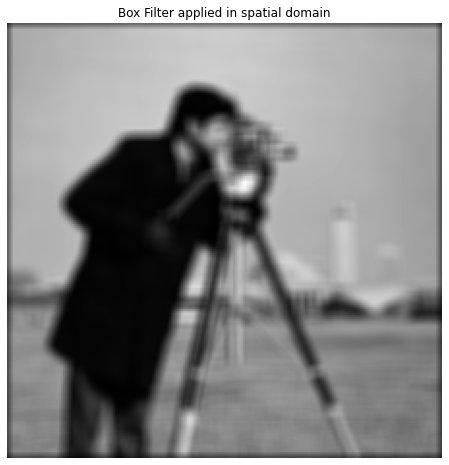

In [13]:
img = cv2.imread('Filtering/cameraman.jpg',0)

# Defining box filter of size 7
size=7
box_filter = ((1/(size*size))*np.ones((size,size))).astype(np.float32)

start_time = time.time()
filter_spatial = convolve2d(img, box_filter, 'same')
end_time = time.time()
timing1 = end_time-start_time

# Display results
print ("Time taken = %f seconds" %(timing1))
plt.imshow(filter_spatial, cmap = 'gray')
plt.title("Box Filter applied in spatial domain")
plt.axis('off')
plt.show()

### Part b:

Time taken = 0.000867 seconds


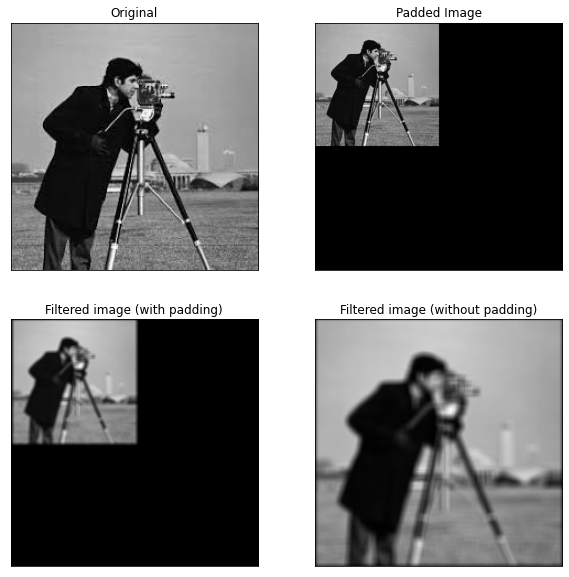

In [14]:
M, N = img.shape
P = 2*M
Q = 2*N

# Padding image and filter
padded_img = pad_img(img, new_shape = (P,Q))
padded_filter = pad_img(box_filter, (P,Q))

# Fourier transform of image and kernel
image_fft =  np.fft.fftshift(np.fft.fft2(padded_img))
kernel_fft = np.fft.fftshift(np.fft.fft2(padded_filter))

start_time = time.time()
conv_fourier = np.multiply(image_fft, kernel_fft)
end_time = time.time()
timing2 = end_time-start_time

transformed_spatial = np.abs(np.fft.ifft2(conv_fourier)).astype(np.uint8)
transformed_spatial_cut = transformed_spatial[3:3+M,3:3+N]

# Display results
print ("Time taken = %f seconds" %(timing2))
disp_subplots([img, padded_img, transformed_spatial, transformed_spatial_cut],
              (2,2),['Original','Padded Image', 'Filtered image (with padding)',
              'Filtered image (without padding)'], None,[None]*4, (10,10),
              cmap='gray')

### Part c:

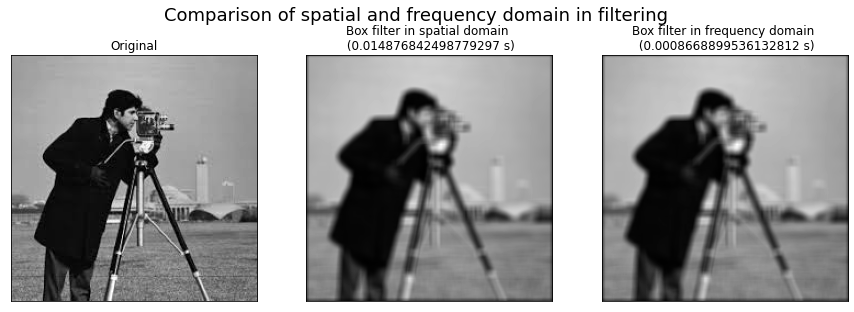

In [15]:
disp_subplots([img, filter_spatial, transformed_spatial_cut],
              (1,3),['Original',f'Box filter in spatial domain \n ({timing1} s)',
              f'Box filter in frequency domain \n ({timing2} s)'],
              'Comparison of spatial and frequency domain in filtering',[None]*3,
              (15,5), cmap='gray')

We can conclude that frequency domain operation is around 10 times faster than convolution in the spatial domain.